In [32]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import QuantileTransformer

from feature_engine.encoding import WoEEncoder
import random
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import balanced_accuracy_score
import sklearn.metrics as metrics

In [33]:
# Load the data
df = pd.read_excel('default of credit card clients.xls', header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Exploratory Data Analysis:

In [34]:
miss_df = pd.DataFrame({'Miss_count':df.isnull().sum(),'Miss_per':df.isnull().mean()*100,'Cardinality':df.nunique()})
miss_df.sort_values('Miss_per',ascending=False)

,Miss_count,Miss_per,Cardinality
LIMIT_BAL,0,0.0,81
SEX,0,0.0,2
PAY_AMT6,0,0.0,6939
PAY_AMT5,0,0.0,6897
PAY_AMT4,0,0.0,6937
PAY_AMT3,0,0.0,7518
PAY_AMT2,0,0.0,7899
PAY_AMT1,0,0.0,7943
BILL_AMT6,0,0.0,20604
BILL_AMT5,0,0.0,21010


1) <b>From the above df we find there's no feature with missing value and no feature with cardinality 1

In [35]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [36]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [37]:
# deepchecks library gives a quick outlook on the sanity of the data
from deepchecks.tabular.suites import data_integrity
from deepchecks.tabular import Dataset

ds = Dataset(df, label='default payment next month', cat_features=['PAY_1', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','SEX','EDUCATION','MARRIAGE'])

integ_suite = data_integrity()
integ_suite_result = integ_suite.run(ds)
integ_suite_result.show()

/Users/pchandran/miniconda3/lib/python3.9/site-packages/deepchecks/core/serialization/suite_result/widget.py:154: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Accordion(children=(VBox(children=(HTML(value='\n            <h1 id="summary_97VK54D5CVD30IQQ591LA49UX">Data I…

1)<b> Deepchecks shows there are duplicate rows with conflicting labels which will be addressed in the data cleaning part

Text(0.5, 1.0, 'Credit Card Default Counts')

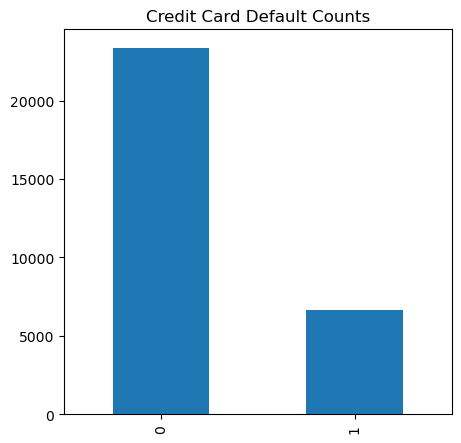

In [38]:
pd.value_counts(df['default payment next month']).plot.bar()
plt.title("Credit Card Default Counts")

29    1605
27    1477
28    1409
30    1395
26    1256
31    1217
25    1186
34    1162
32    1158
33    1146
Name: AGE, dtype: int64


Text(0.5, 1.0, 'Age Distribution')

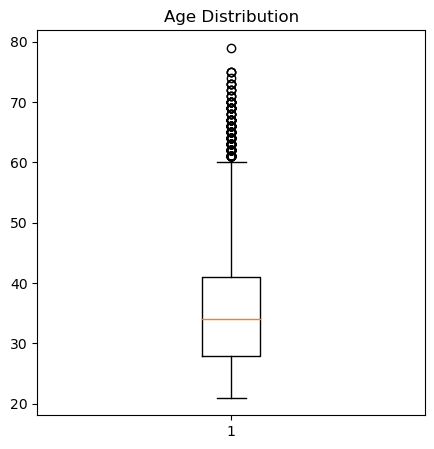

In [39]:
print(df['AGE'].value_counts().nlargest(10))
plt.boxplot(df['AGE']) 
plt.title("Age Distribution")

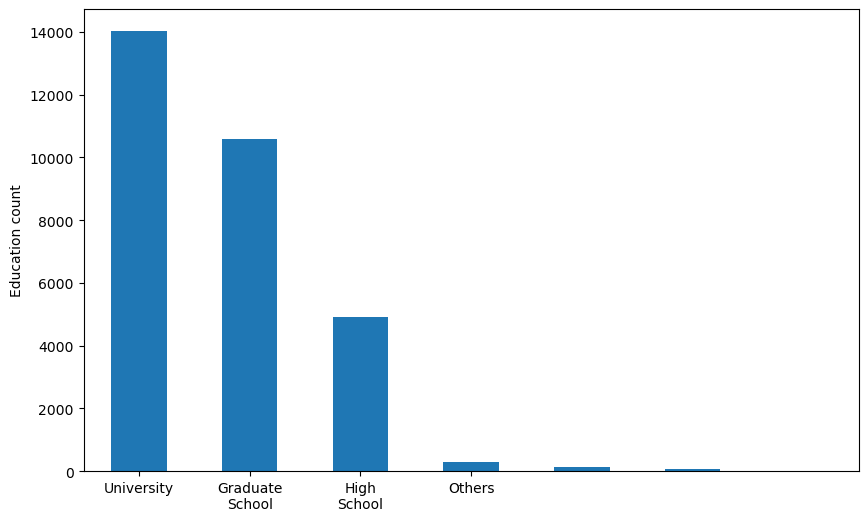

In [40]:
# 1=graduate school, 2=university, 3=high school 4=others
df['EDUCATION'].value_counts().plot(kind='bar', figsize=(10,6))
plt.xticks([0,1,2,3],['University','Graduate\nSchool', 'High\nSchool', 'Others'],rotation=0)
plt.ylabel('Education count')
plt.show()

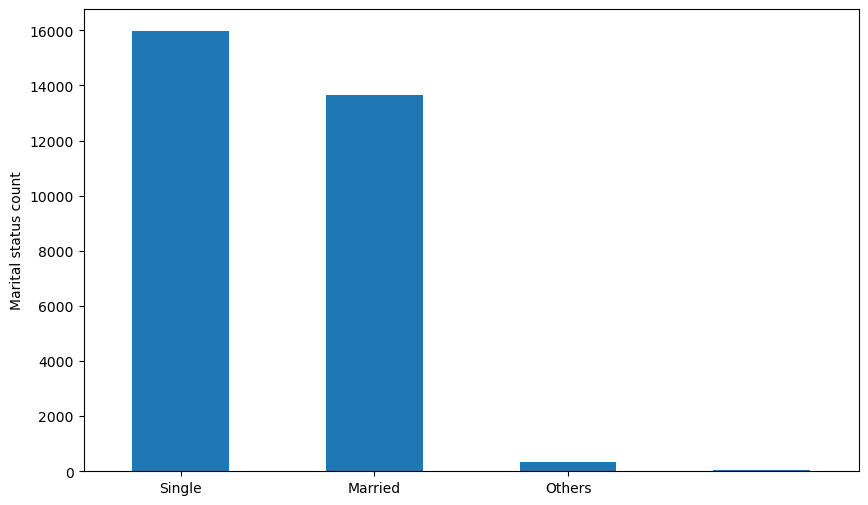

In [41]:
# 1=married, 2=single, 3=others
df['MARRIAGE'].value_counts().plot(kind='bar', figsize=(10,6))
plt.xticks([0,1,2],['Single','Married', 'Others'],rotation=0)
# plt.xlabel('Marital Status', fontproperties=font)
plt.ylabel('Marital status count')
plt.show()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64


<AxesSubplot:xlabel='PAY_6', ylabel='count'>

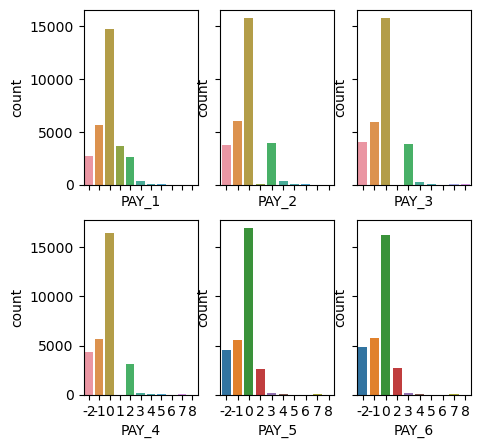

In [42]:
print(df['PAY_1'].value_counts())
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
sns.countplot(x="PAY_1", data=df, ax=ax[0,0])
sns.countplot(x="PAY_2", data=df, ax=ax[0,1])
sns.countplot(x="PAY_3", data=df, ax=ax[0,2])
sns.countplot(x="PAY_4", data=df, ax=ax[1,0])
sns.countplot(x="PAY_5", data=df, ax=ax[1,1])
sns.countplot(x="PAY_6", data=df, ax=ax[1,2])

<b> pay delay/ not delay count plot. Every month from April - August 2005 1 month payment delay is the highest

Text(0.5, 1.0, 'Default by Education and Sex')

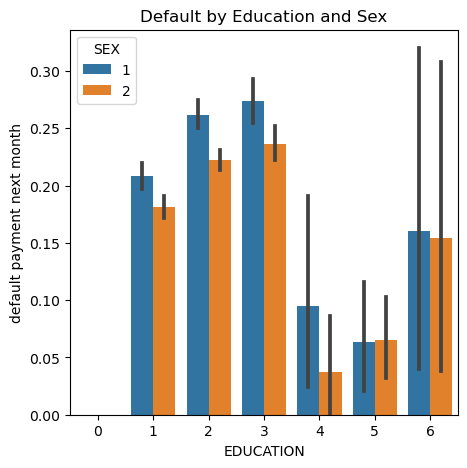

In [43]:
df['default payment next month'].value_counts()
sns.barplot(x="EDUCATION", y="default payment next month", hue="SEX", data=df)
plt.title("Default by Education and Sex")

<b> More male default with education - graduate school, university, high school, others while education 5, 6 wheere male & female are similar are unknown education type

Text(0.5, 1.0, 'Distribution of Default by Age')

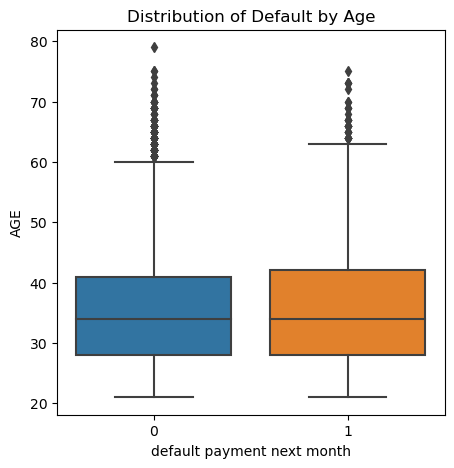

In [44]:
sns.boxplot(x="default payment next month", y="AGE", data=df)
plt.title("Distribution of Default by Age")

<b> By average both look similar but more older people are slightly more probable to default next month

Text(0.5, 1.0, 'Distribution of Default by Sex and Age')

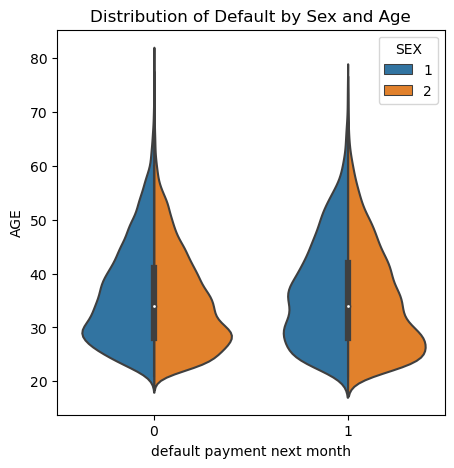

In [45]:
sns.violinplot(x="default payment next month", y="AGE", hue="SEX", data=df, split=True)
plt.title("Distribution of Default by Sex and Age")

<b> Male slightly more probability to default but it's almost similar

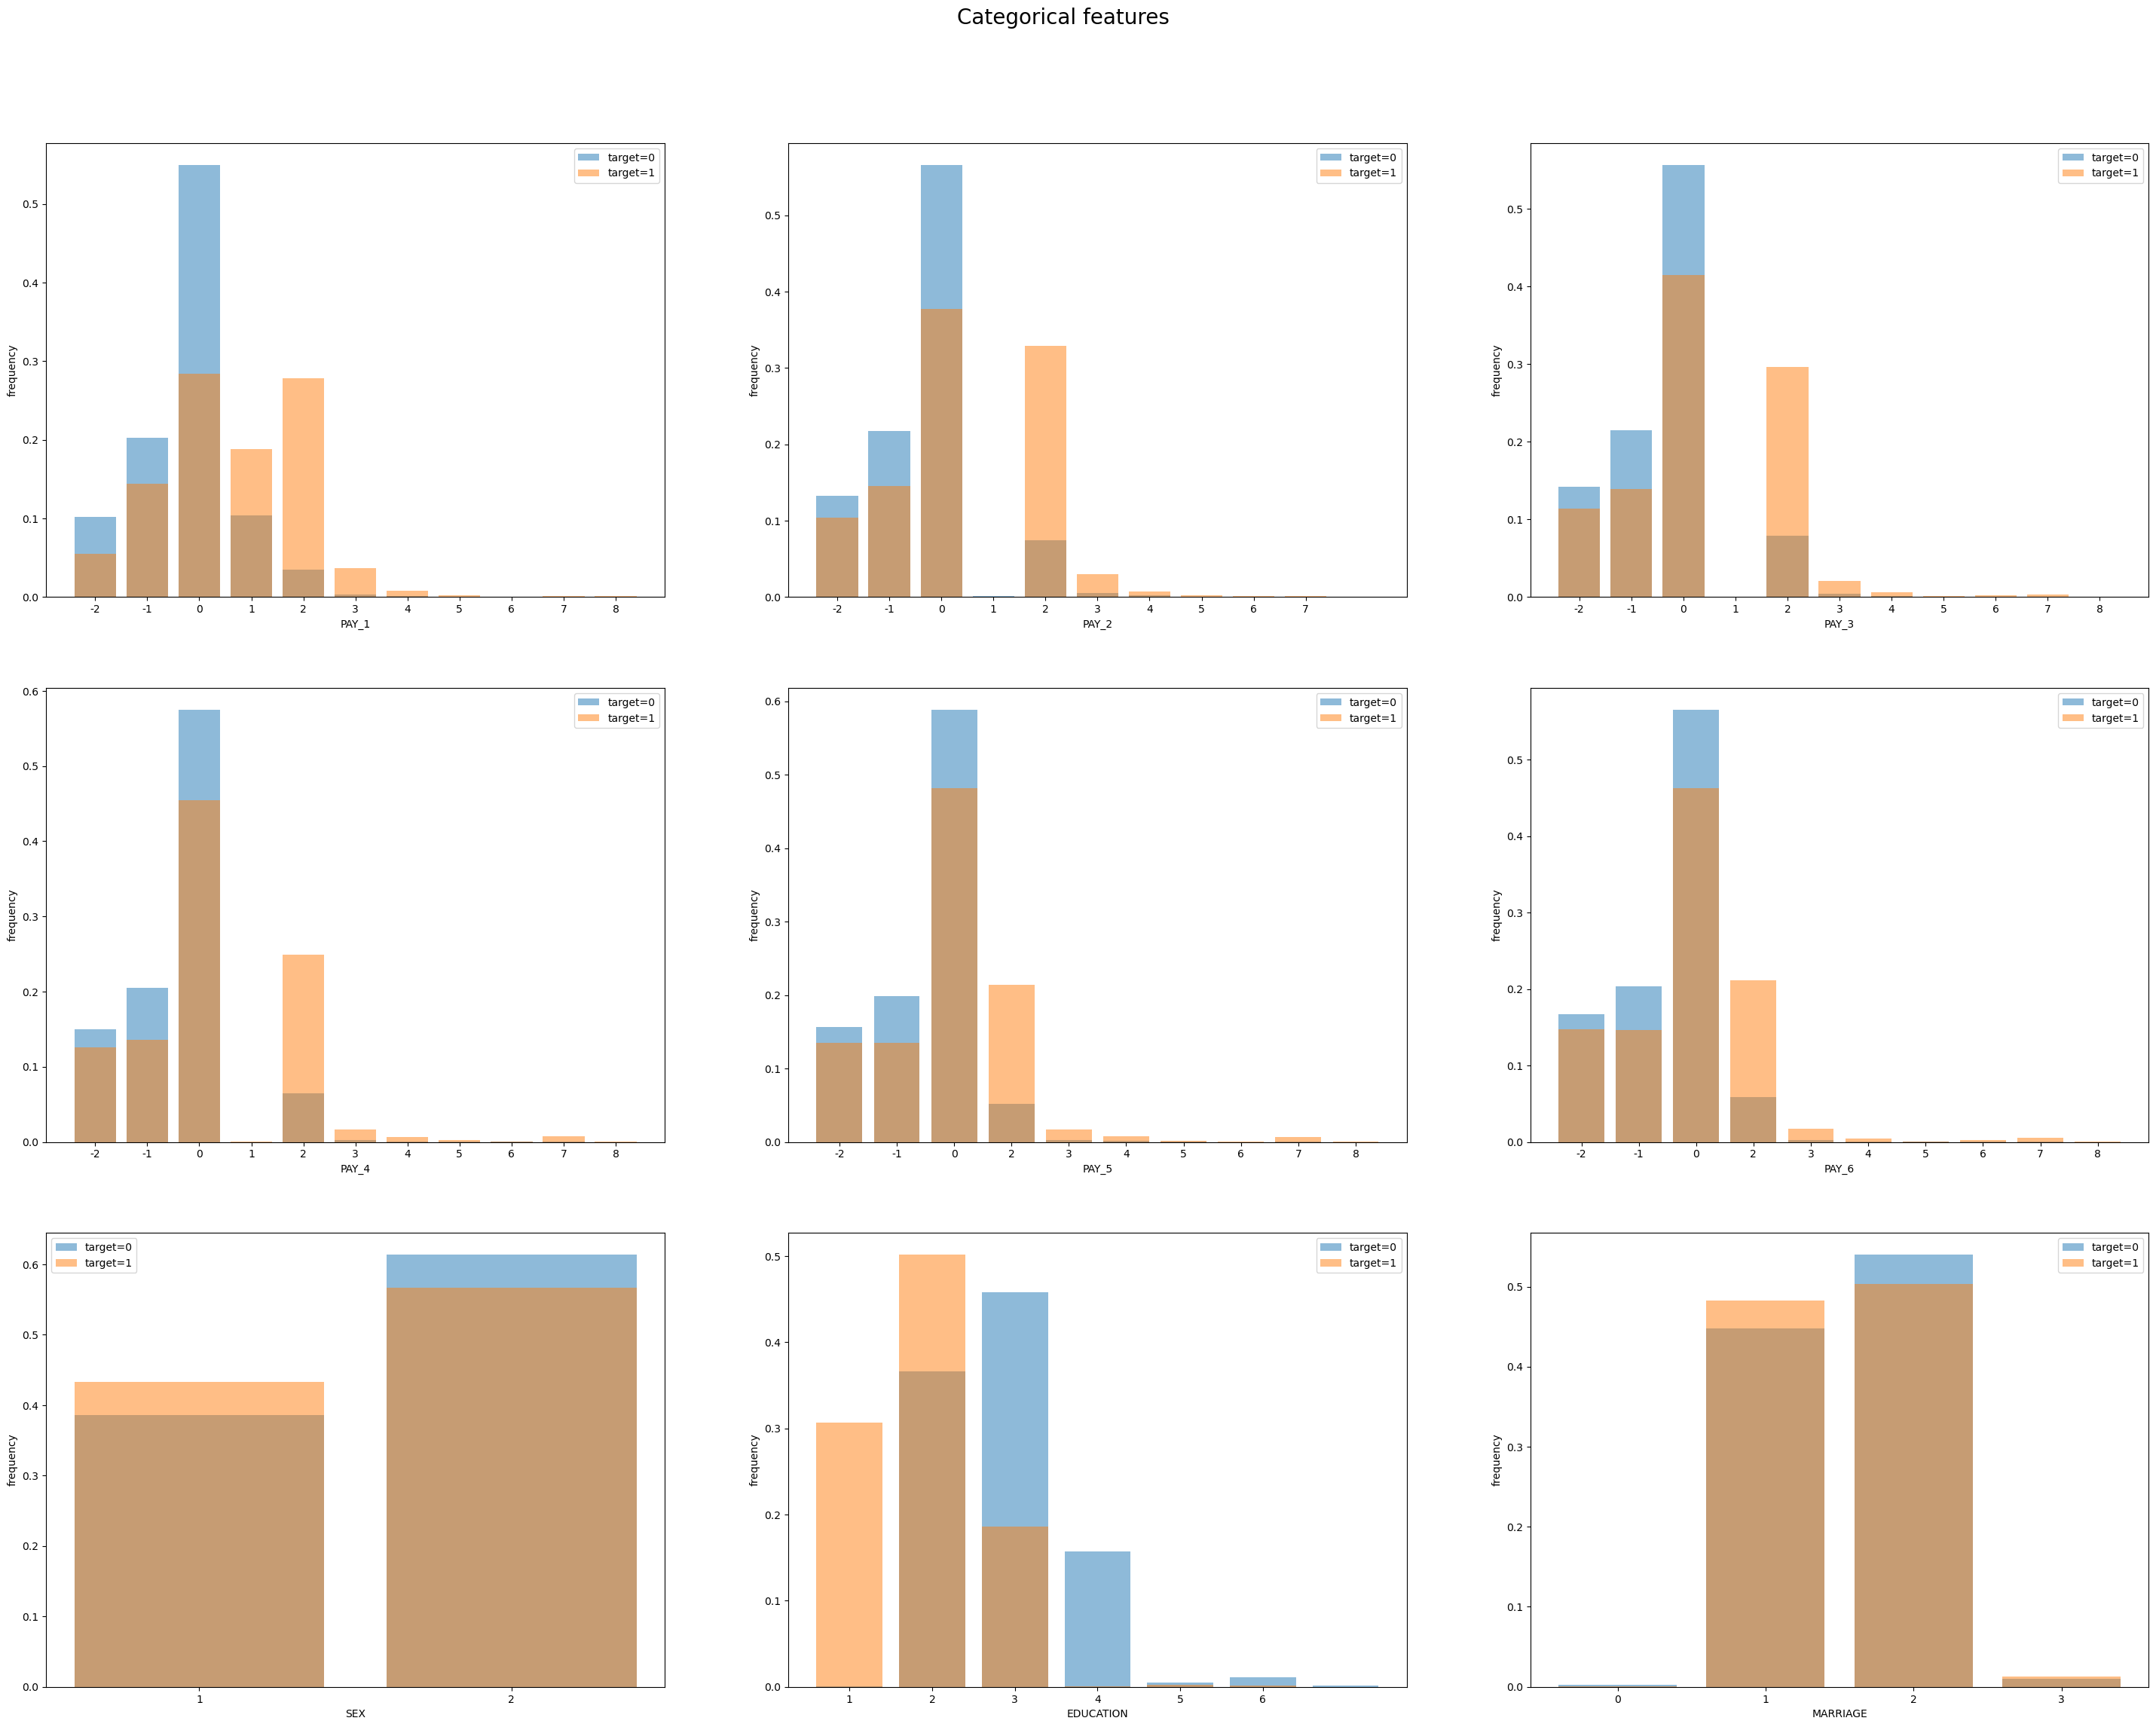

In [49]:
plt.figure(figsize=(36, 36))
for i, f in enumerate(['PAY_1', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','SEX','EDUCATION','MARRIAGE']):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(df[f][df['default payment next month'] == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(df[f][df['default payment next month'] == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()

<b>1) More payment delays result in default next month as expected <br>
    2) Male more likely to default next month than female <br>
    3) People with graduate school, university education are more likely to default next month <br>
    4) Married people more likely to default

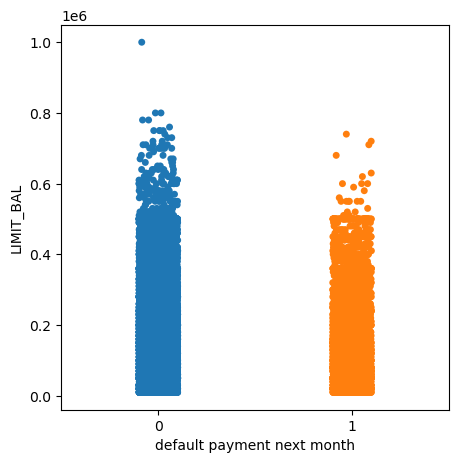

In [51]:
sns.stripplot(x='default payment next month',y='LIMIT_BAL', data=df,jitter=True)
plt.show()

<b> Average credit balance is bit lower for people who default next month. Further analysis required for people with higher credit balance (few people) and default

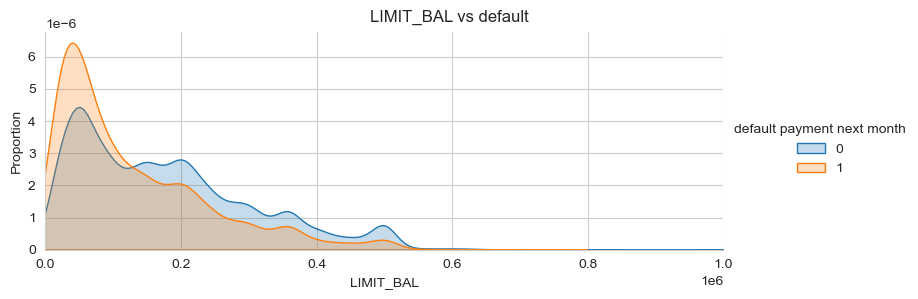

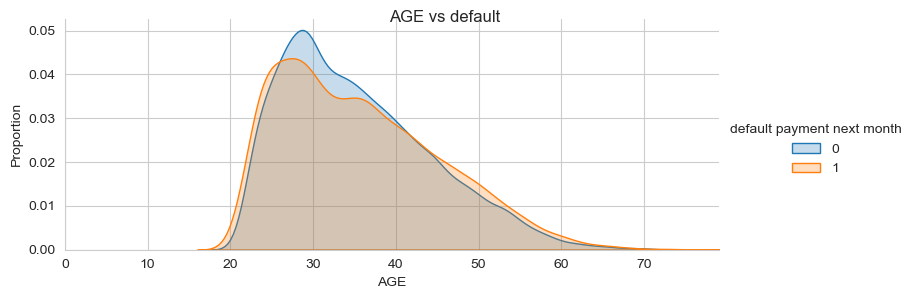

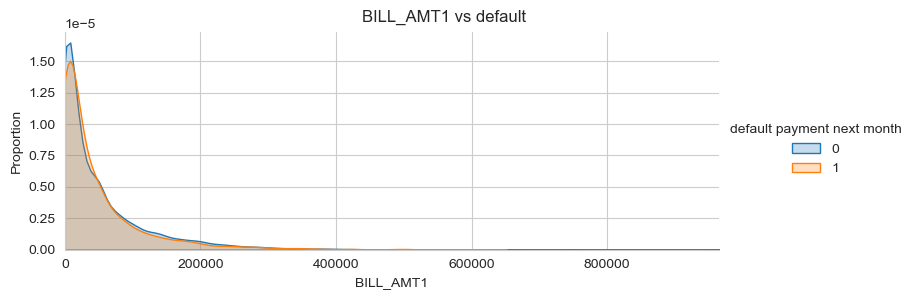

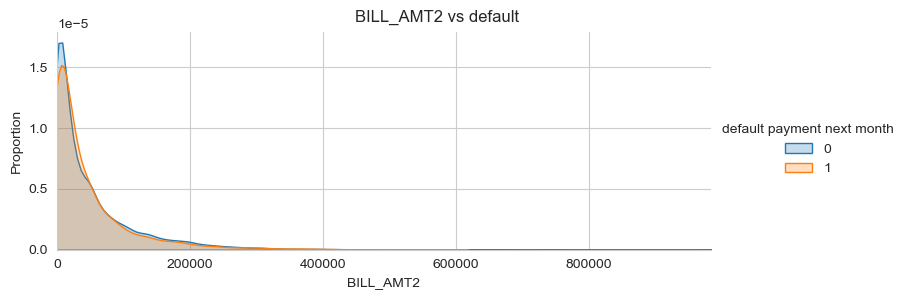

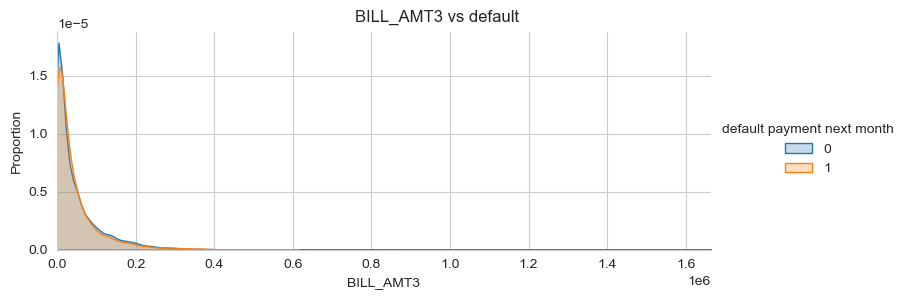

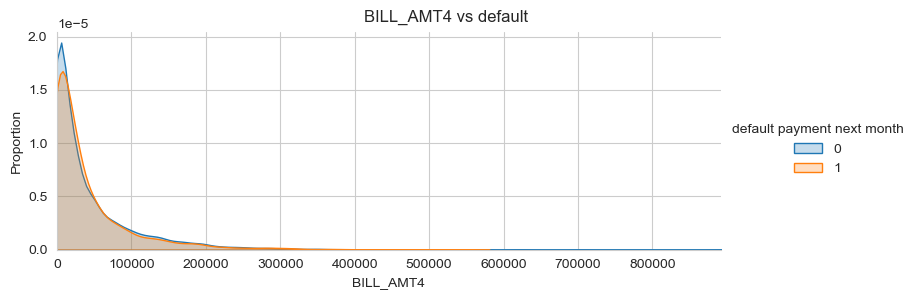

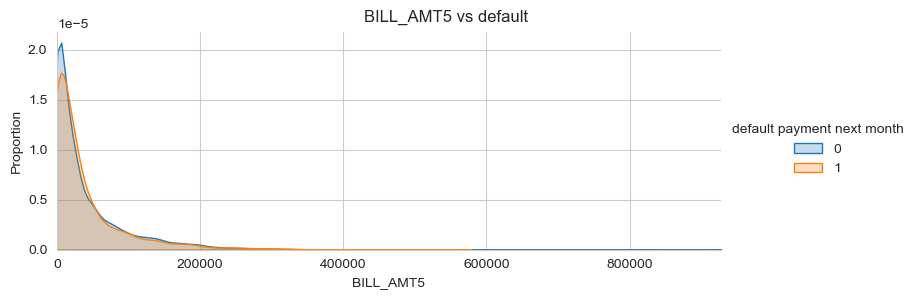

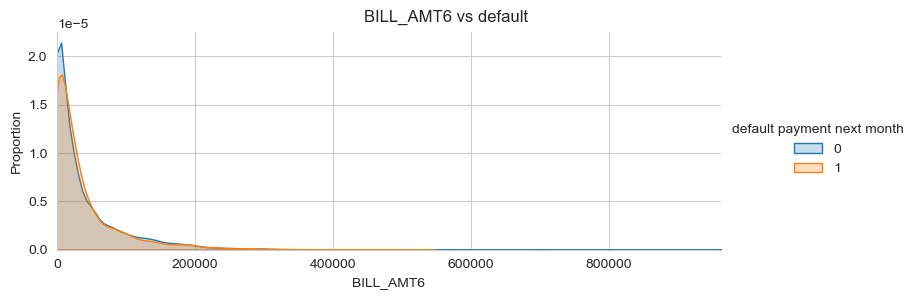

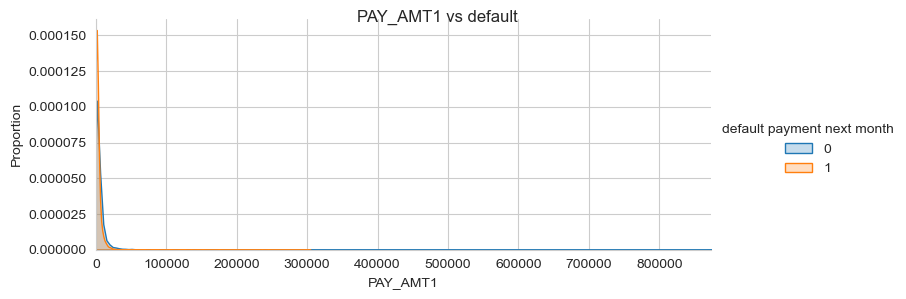

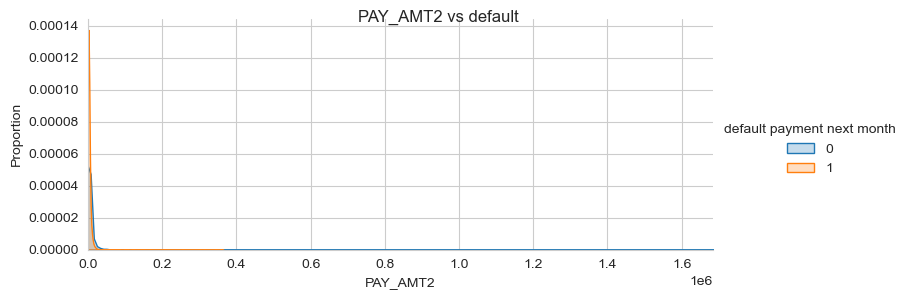

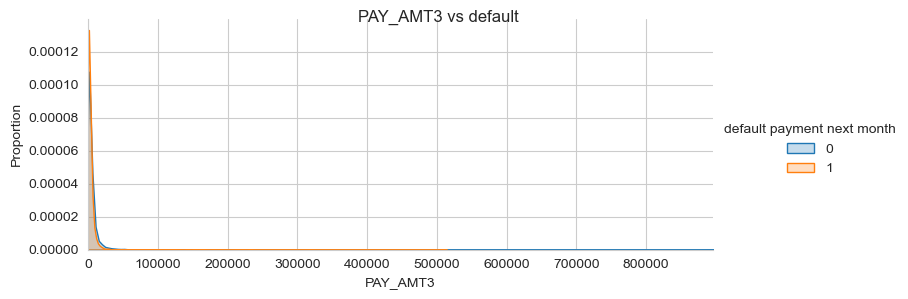

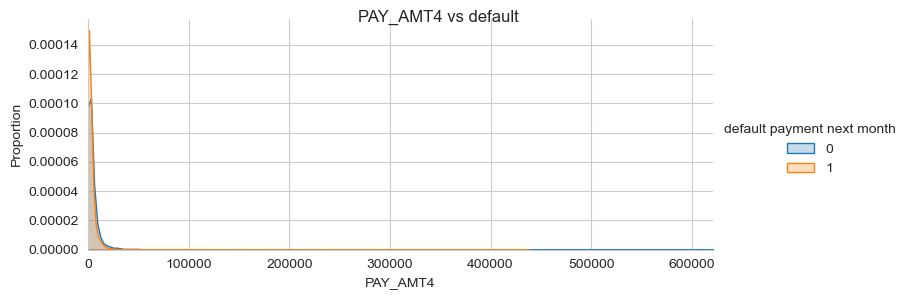

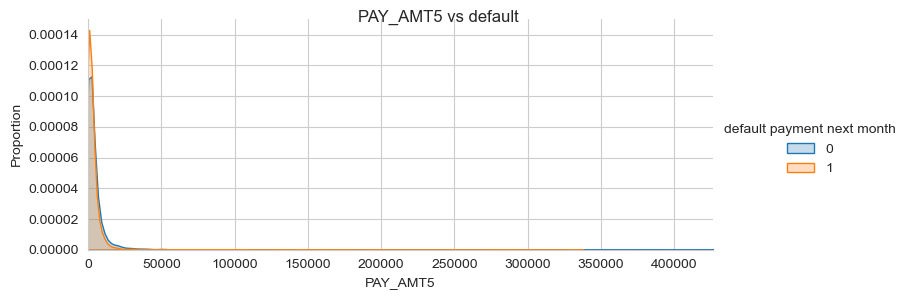

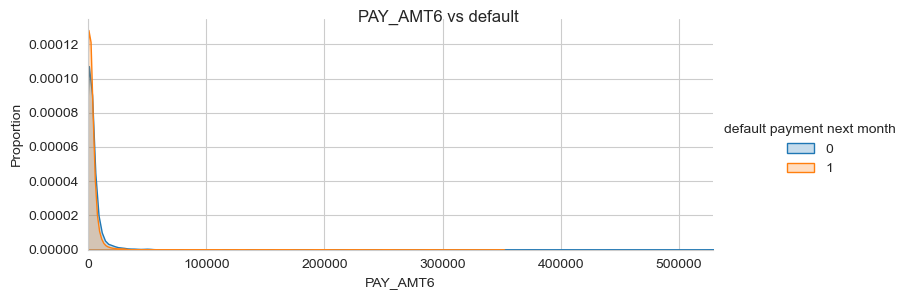

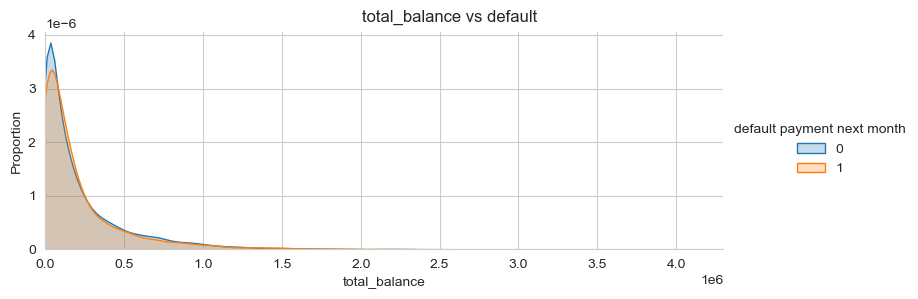

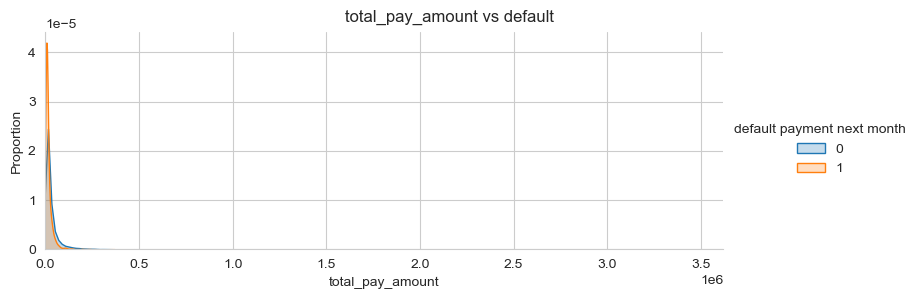

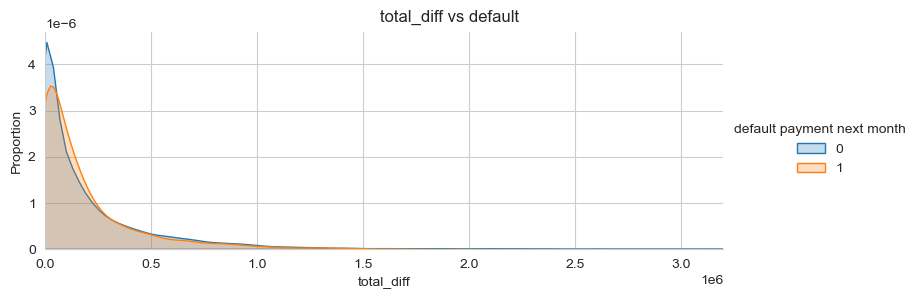

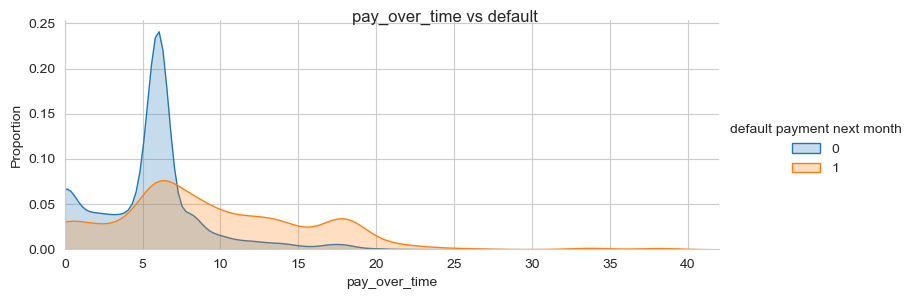

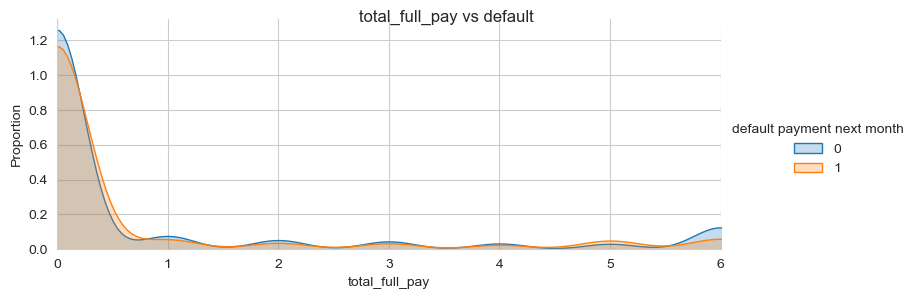

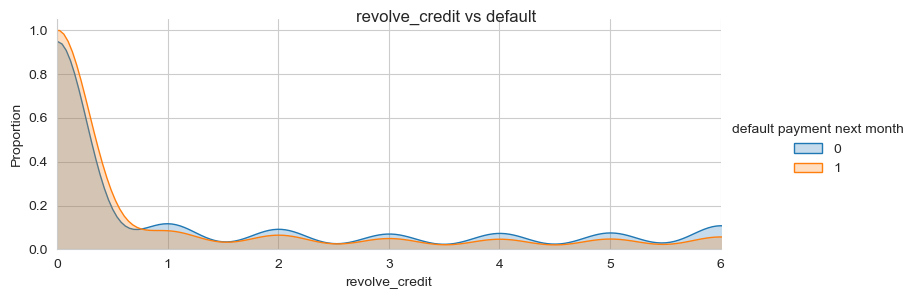

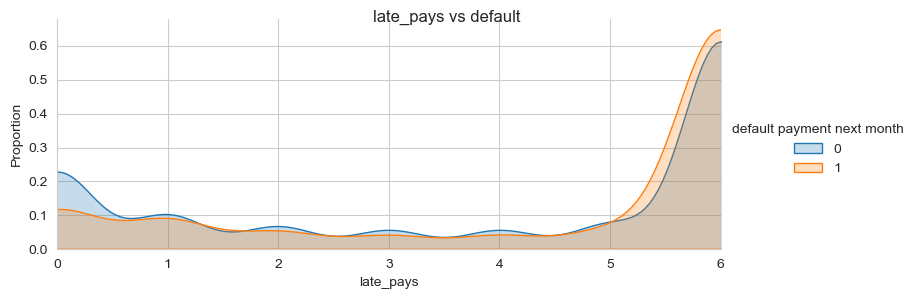

In [55]:
def proportion_plot(col, df, target):
    sns.set_style("whitegrid")
    plotOne = sns.FacetGrid(df, hue= target,  aspect= 2.5)
    plotOne.map(sns.kdeplot, col,  shade=True)
    plotOne.set(xlim=(0, df[col].max()))
    plotOne.add_legend()
    plotOne.set_axis_labels(col, 'Proportion')
    plotOne.fig.suptitle('{0} vs default'.format(col))
    plt.show()
    
cols = ['LIMIT_BAL','AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
             'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6','total_balance','total_pay_amount','total_diff',
             'pay_over_time','total_full_pay','revolve_credit','late_pays']
for col in cols:
    proportion_plot(col, df, 'default payment next month')

<b>1) Lesser the credit balance, more the default is next month which is clearly interpret from the plot <br>
    2) Age between 26-40 have more non default while ages less than 25 and above 45 have slightly higher default <br>
    3) The difference between past bill statements and amount paid (total_diff), if lesser then probability of default next month is low <br>
    4) More the person has delayed payments in the past, highly likely going to default next month. Interesting peak of no-default for delay values between 4 and 7.5
    5) Neeed further analysis on why people who paid full 5 times have slightly higher default next month probability
    6) As expected, people with more number of late pays have higher probability of default next month

### Segregating numeric and categorical features 

In [47]:
num_cols = ['LIMIT_BAL','AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
             'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6','total_balance','total_pay_amount','total_diff',
             'pay_over_time','total_full_pay','revolve_credit','late_pays', 'random']

cat_cols = ['SEX','EDUCATION','MARRIAGE']

# Data pre-processing:

In [6]:
def df_pre_split_ft_engg(df):
    '''Function to derive new features and clean/ remove unnecessary data before train/ test split'''
    # dropping duplicate rows
    df = df.drop_duplicates()
    
    
    # category '0' undocumented is deleted
    df = df.drop(df[df['MARRIAGE']==0].index)

    # categories 0, 5 and 6 are unknown and are deleted
    df = df.drop(df[df['EDUCATION']==0].index)
    df = df.drop(df[df['EDUCATION']==5].index)
    df = df.drop(df[df['EDUCATION']==6].index)
    
    # adding 1 since the categories vary from -1 to 9 and assume it was a typo
    df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] += 1
    
    total_balance=df[['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
    df['total_balance']=total_balance.sum(axis=1)
    
    total_pay_amount=df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5']]
    df['total_pay_amount']=total_pay_amount.sum(axis=1)
    
    df['total_diff']=df['total_balance']-df['total_pay_amount']
    
    pay_len=df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
    df['pay_over_time']=pay_len.sum(axis=1)
    
    df['total_full_pay']=(pay_len ==-1 ).sum(axis=1)
    df['revolve_credit']=(pay_len ==0 ).sum(axis=1)
    df['late_pays']=(pay_len >0 ).sum(axis=1)
    
    # from deepchecks we figured out there 0.14% of duplicate rows with conflicting target default
    # we are removing one of the duplicate rows randomly
    df['Duped'] = df.duplicated(subset=['LIMIT_BAL','AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
             'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6','total_balance','total_pay_amount','total_diff',
             'pay_over_time','total_full_pay','revolve_credit','late_pays','PAY_1', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','SEX','EDUCATION',
                                    'MARRIAGE'], keep=False).astype(int)

    df.loc[df['Duped'] == 1, 'default payment next month'] = 2
    df = df.drop(columns=['Duped','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' , 'PAY_6'])
    df = df[df['default payment next month'] != 2]
    
    # introducing a random normally distributed feature to better understand the important predictors
    df['random'] = [np.random.normal(-5,5) for _ in range(len(df))]
    
    df[cat_cols] = df[cat_cols].astype('category')
    return df

In [7]:
df['default payment next month'].value_counts(dropna=False)

0    23364
1     6636
Name: default payment next month, dtype: int64

In [8]:
def df_post_split_eng(df):
    '''function to select best features and apply transformations after split to avoid leakage to test data'''
    # from permutation importance select the features better than random
#     df = df[['pay_over_time','LIMIT_BAL','total_pay_amount','BILL_AMT1','PAY_AMT1','PAY_AMT3','PAY_AMT2','PAY_AMT6',
#             'default payment next month']]
    # split data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(df,df['default payment next month'], test_size=0.2)
    
    num_df = X_train[num_cols]

    # applying quantile transformation to all the features for conversion to normal distribution

    quantile = QuantileTransformer(output_distribution='normal')
    num_df_trans = pd.DataFrame(quantile.fit_transform(num_df),columns = num_df.columns)
    
    # applying weight of evidence transformation for categorical features so that feature space is not further expanded
    # while using one hot encoding
    
    cat_df = X_train[cat_cols]
    woe_encoder = WoEEncoder(variables=cat_cols)
    woe_encoder.fit(cat_df, Y_train)
    woe_df = woe_encoder.transform(cat_df)
    num_df_trans = num_df_trans.reset_index()
    del num_df_trans['index']
    woe_df = woe_df.reset_index()
    del woe_df['index']
    X_train = pd.concat([num_df_trans,woe_df], axis=1)
    X_train = X_train[['pay_over_time','LIMIT_BAL','total_pay_amount','BILL_AMT1','PAY_AMT1','PAY_AMT3','PAY_AMT2','PAY_AMT6']]
    
    # applying transformations to test data
    test_num_df = X_test[num_cols]
    test_num_df_trans = pd.DataFrame(quantile.transform(test_num_df),columns = test_num_df.columns)
    test_cat_df = X_test[cat_cols]
    test_woe_df = woe_encoder.transform(test_cat_df)
    #del test_num_df_trans['index']
    test_woe_df = test_woe_df.reset_index()
    #del test_woe_df['index']
    X_test = pd.concat([test_num_df_trans,test_woe_df], axis=1)
    X_test = X_test[['pay_over_time','LIMIT_BAL','total_pay_amount','BILL_AMT1','PAY_AMT1','PAY_AMT3','PAY_AMT2','PAY_AMT6']]
    
    train = pd.concat([num_df_trans,woe_df,Y_train], axis=1)
    return train, X_train, Y_train, X_test,  Y_test
    
    

In [54]:
df = df_pre_split_ft_engg(df)
train, X_train, Y_train, X_test,  Y_test = df_post_split_eng(df)

In [10]:
train, X_train, Y_train, X_test,  Y_test = df_post_split_eng(df)

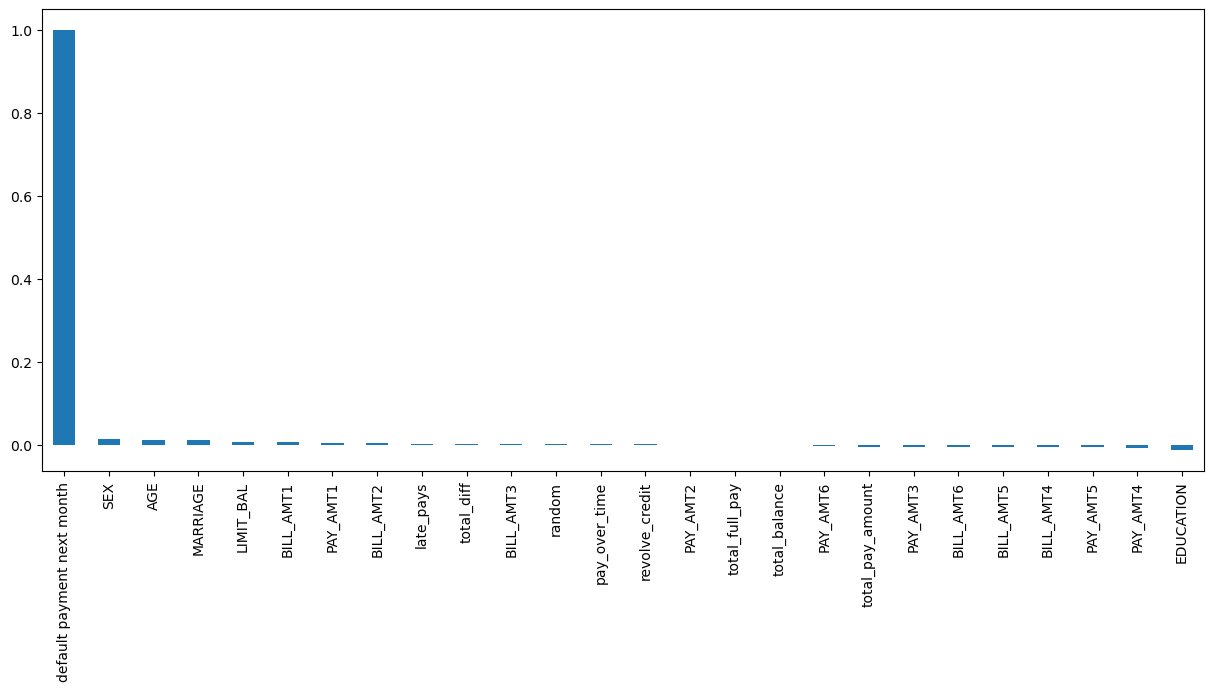

In [11]:
# plot to show how predictors are correlated with the target
plt.figure(figsize=(15,6))
bars = train.corr()['default payment next month'].sort_values(ascending=False).plot(kind='bar')

In [12]:
import ppscore  as pps
# Predictive power score is used instead of correlation since PPS can address both linear/ non-linear relationship
# between the features whereas correlation only shows linear relationship
c=pps.matrix(train)

In [13]:
c = c.sort_values(by=['ppscore'], ascending=False)

In [14]:
c[(c['ppscore'] > 0.5) & (c['ppscore'] < 1)]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
462,pay_over_time,late_pays,0.840092,regression,True,mean absolute error,3.403171,0.544193,DecisionTreeRegressor()
430,total_diff,total_balance,0.719123,regression,True,mean absolute error,0.795576,0.223459,DecisionTreeRegressor()
461,pay_over_time,revolve_credit,0.695319,regression,True,mean absolute error,2.353494,0.717065,DecisionTreeRegressor()
144,BILL_AMT4,total_balance,0.646081,regression,True,mean absolute error,0.795576,0.281569,DecisionTreeRegressor()
118,BILL_AMT3,total_balance,0.633428,regression,True,mean absolute error,0.795576,0.291636,DecisionTreeRegressor()
369,total_balance,BILL_AMT4,0.627370,regression,True,mean absolute error,0.795981,0.296606,DecisionTreeRegressor()
368,total_balance,BILL_AMT3,0.619774,regression,True,mean absolute error,0.799511,0.303995,DecisionTreeRegressor()
380,total_balance,total_diff,0.615284,regression,True,mean absolute error,0.797738,0.306903,DecisionTreeRegressor()
170,BILL_AMT5,total_balance,0.602385,regression,True,mean absolute error,0.795576,0.316333,DecisionTreeRegressor()
460,pay_over_time,total_full_pay,0.596719,regression,True,mean absolute error,1.604462,0.647049,DecisionTreeRegressor()


<AxesSubplot:xlabel='x', ylabel='y'>

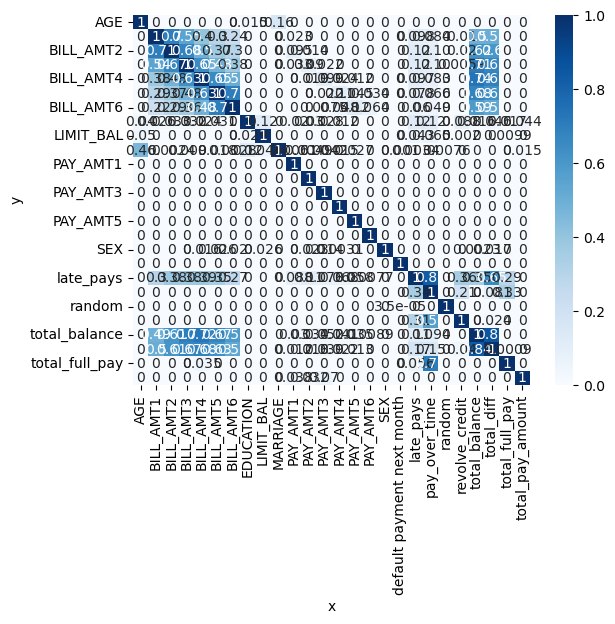

In [15]:
import seaborn as sns
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, cmap="Blues", annot=True)

In [16]:
matrix_df

x,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION,LIMIT_BAL,MARRIAGE,...,SEX,default payment next month,late_pays,pay_over_time,random,revolve_credit,total_balance,total_diff,total_full_pay,total_pay_amount
y,,,,,,,,,,,,,,,,,,,,,
AGE,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015195,0.000000,0.156688,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BILL_AMT1,0.000000,1.000000,0.700190,0.548389,0.404292,0.298940,0.240369,0.000000,0.000000,0.000000,...,0.0,0.000000,0.097526,0.084244,0.000000,0.010004,0.499737,0.506663,0.000000,0.000000
BILL_AMT2,0.000000,0.700551,1.000000,0.678274,0.495405,0.374582,0.304407,0.000000,0.000000,0.000000,...,0.0,0.000000,0.119737,0.104425,0.000000,0.019504,0.622175,0.602805,0.000000,0.000000
BILL_AMT3,0.000000,0.541279,0.671557,1.000000,0.646270,0.481557,0.380219,0.000000,0.000000,0.000000,...,0.0,0.000000,0.118113,0.104080,0.000000,0.005864,0.711440,0.674914,0.000000,0.000000
BILL_AMT4,0.000000,0.377884,0.478439,0.633463,1.000000,0.652843,0.505130,0.000000,0.000000,0.000000,...,0.0,0.000000,0.097331,0.082984,0.000000,0.000000,0.735112,0.688946,0.000000,0.000000
BILL_AMT5,0.000000,0.293631,0.373551,0.475461,0.628657,1.000000,0.705238,0.000000,0.000000,0.000000,...,0.0,0.000000,0.077827,0.065524,0.000000,0.000000,0.679707,0.631862,0.000000,0.000000
BILL_AMT6,0.000000,0.217297,0.289920,0.361055,0.481561,0.702589,1.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.059806,0.049013,0.000000,0.000000,0.587597,0.530711,0.000000,0.000000
EDUCATION,0.039761,0.026472,0.033061,0.032415,0.023610,0.030519,0.000000,1.000000,0.124009,0.000000,...,0.0,0.000000,0.121668,0.115106,0.000000,0.088005,0.015994,0.045564,0.017333,0.044374
LIMIT_BAL,0.050499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028932,1.000000,0.000000,...,0.0,0.000000,0.043348,0.064618,0.000000,0.002039,0.000000,0.000000,0.009865,0.000000


In [17]:
X_train

,pay_over_time,LIMIT_BAL,total_pay_amount,BILL_AMT1,PAY_AMT1,PAY_AMT3,PAY_AMT2,PAY_AMT6
0,1.104747,-0.842694,-0.619142,-0.209610,-0.106841,-0.657789,0.110627,-0.503497
1,-1.301191,1.705570,-0.865022,-0.855287,0.556341,-5.199338,-5.199338,-5.199338
2,0.229064,0.683178,0.310778,0.901963,0.364191,0.513491,0.430727,0.570161
3,-1.181921,-1.644369,-1.546982,-0.343378,-5.199338,-5.199338,-0.697653,-5.199338
4,0.229064,0.611996,-0.829659,-0.324779,-0.496390,-0.269184,-0.437620,-0.503497
...,...,...,...,...,...,...,...,...
23614,0.229064,-1.228607,-0.708752,0.161542,-0.470582,-0.035135,-0.313694,-0.659602
23615,-1.301191,-0.842694,-1.164444,-2.660948,-5.199338,-0.005018,-0.665124,-5.199338
23616,-1.418119,-0.254902,-5.199338,-0.631640,-5.199338,-5.199338,-5.199338,-5.199338
23617,1.104747,0.734798,0.839100,1.331800,0.922330,0.920412,1.483842,1.033991


# Feature selection:

In [268]:
# using permutation importance to find the top features since it's more accurate than normal feature importance methods
# We can clearly see more features have lesser importance than randomly created feature 'random' which are not  useful
rf = RandomForestClassifier(n_jobs = -1, 
                            random_state = 101)
perm = PermutationImportance(rf.fit(X_train, 
                                    Y_train), 
                             random_state=1).fit(X_train,
                                                 Y_train)
eli5.show_weights(perm, 
                  feature_names = X_train.columns.tolist(), 
                  top=(30))

Weight,Feature
0.1934 ± 0.0008,pay_over_time
0.1119 ± 0.0020,LIMIT_BAL
0.1098 ± 0.0020,total_pay_amount
0.1041 ± 0.0029,BILL_AMT1
0.1040 ± 0.0019,PAY_AMT1
0.0980 ± 0.0021,PAY_AMT2
0.0934 ± 0.0027,PAY_AMT3
0.0881 ± 0.0017,PAY_AMT6


# Modeling:

In [18]:
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [270]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'scale_pos_weight' : hp.quniform('scale_pos_weight', 3, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

#  Baseline Logistic Regression:

<b> SMOTE, Undersampling, Oversampling are conciously avoided since to develop better imbalanced classification model,
    better metric and class weights are used

In [56]:
def lr_prediction(X_train, Y_train):
    clf_reg=LogisticRegression(solver= 'lbfgs', class_weight = 'balanced' )
    clf_reg.fit(X_train,Y_train)
    Y_pred_logr=clf_reg.predict(X_train)
    Y_predict_logr=clf_reg.predict(X_test)
    return Y_predict_logr

In [57]:
Y_predict_logr = lr_prediction(X_train, Y_train)

In [58]:
# using balanced accuracy for imbalanced data
accuracy = balanced_accuracy_score(Y_test, Y_predict_logr)

In [59]:
print(accuracy)

0.6794529772441673


In [60]:
print(classification_report(Y_test,Y_predict_logr))

              precision    recall  f1-score   support

           0       0.88      0.71      0.78      4597
           1       0.39      0.65      0.49      1308

    accuracy                           0.69      5905
   macro avg       0.63      0.68      0.63      5905
weighted avg       0.77      0.69      0.72      5905



# XG Boost - Final Model:

In [349]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), scale_pos_weight=int(space['scale_pos_weight']))
    
    evaluation = [( X_train, Y_train), ( X_test, Y_test)]
    
    clf.fit(X_train, Y_train,
            eval_set=evaluation, eval_metric=['aucpr','logloss'],
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    pred = pred.astype('int64')
    accuracy = balanced_accuracy_score(Y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [350]:
# using hyperopt library to find the best hyperparameters for tuning
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                            
0.700204423203403                                                                                                                 
  1%|▌                                                          | 1/100 [00:01<03:04,  1.87s/trial, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5047873306191747                                                                                                                
  2%|█▏                                                         | 2/100 [00:02<01:30,  1.09trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6962432606835973                                                                                                                
  3%|█▊                                                         | 3/100 [00:03<01:39,  1.02s/trial, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5047873306191747                                                                                                                
  4%|██▎                                                        | 4/100 [00:03<01:09,  1.37trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5298950201494751                                                                                                                
  5%|██▉                                                        | 5/100 [00:03<00:54,  1.73trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.698286975931911                                                                                                                 
  6%|███▌                                                       | 6/100 [00:05<01:20,  1.17trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
  7%|████▏                                                      | 7/100 [00:05<01:01,  1.52trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6977452983696788                                                                                                                
  8%|████▋                                                      | 8/100 [00:06<01:13,  1.26trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6979370258706374                                                                                                                
SCORE:                                                                                                                            
0.5297877871132246                                                                                                                
 10%|█████▊                                                    | 10/100 [00:08<01:05,  1.38trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.5049459838342537                                                                                                                
SCORE:                                                                                                                            
0.5297084605056852                                                                                                                
 12%|██████▉                                                   | 12/100 [00:08<00:40,  2.19trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
                                                                                                                                  

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




0.5276926516860823
 13%|███████▌                                                  | 13/100 [00:08<00:34,  2.52trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6982263397411317                                                                                                                
 14%|████████                                                  | 14/100 [00:10<00:57,  1.50trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6996635208197461                                                                                                                
 15%|████████▋                                                 | 15/100 [00:11<01:11,  1.19trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6999384508211208                                                                                                                
SCORE:                                                                                                                            
0.5059958340180745                                                                                                                
 17%|█████████▊                                                | 17/100 [00:12<01:01,  1.35trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.6972651183077542                                                                                                                
SCORE:                                                                                                                            
0.5049459838342537                                                                                                                
 19%|███████████                                               | 19/100 [00:13<00:51,  1.58trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
 20%|███████████▌                                              | 20/100 [00:14<00:41,  1.92trial/s, best loss: -0.700204423203403]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7015715798173817                                                                                                                
 21%|███████████▉                                             | 21/100 [00:15<01:08,  1.16trial/s, best loss: -0.7015715798173817]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5278513049011613                                                                                                                
 22%|████████████▌                                            | 22/100 [00:16<00:55,  1.42trial/s, best loss: -0.7015715798173817]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7031533747657669                                                                                                                
 23%|█████████████                                            | 23/100 [00:18<01:29,  1.16s/trial, best loss: -0.7031533747657669]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5505232110859494                                                                                                                
 24%|█████████████▋                                           | 24/100 [00:18<01:11,  1.07trial/s, best loss: -0.7031533747657669]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.703736653578207                                                                                                                 
SCORE:                                                                                                                            
0.5275853325188791                                                                                                                
 26%|███████████████                                           | 26/100 [00:21<01:23,  1.12s/trial, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
 27%|███████████████▋                                          | 27/100 [00:22<01:02,  1.17trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5276926516860823                                                                                                                
 28%|████████████████▏                                         | 28/100 [00:22<00:48,  1.49trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.696765472650494                                                                                                                 
 29%|████████████████▊                                         | 29/100 [00:23<00:56,  1.27trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7033400205405096                                                                                                                
SCORE:                                                                                                                            
 30%|█████████████████▍                                        | 30/100 [00:25<01:15,  1.08s/trial, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




0.5277719782936218                                                                                                                
 31%|█████████████████▉                                        | 31/100 [00:25<00:58,  1.19trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6973580536058379                                                                                                                
 32%|██████████████████▌                                       | 32/100 [00:26<01:08,  1.01s/trial, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
 33%|███████████████████▏                                      | 33/100 [00:27<00:56,  1.18trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5507098568606921                                                                                                                
 34%|███████████████████▋                                      | 34/100 [00:27<00:47,  1.40trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6991549175433937                                                                                                                
 35%|████████████████████▎                                     | 35/100 [00:29<01:10,  1.09s/trial, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5277719782936218                                                                                                                
 36%|████████████████████▉                                     | 36/100 [00:30<00:55,  1.15trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6998824657017932                                                                                                                
 37%|█████████████████████▍                                    | 37/100 [00:31<01:11,  1.14s/trial, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6977690705126549                                                                                                                
SCORE:                                                                                                                            
0.5297877871132246                                                                                                                
 39%|██████████████████████▌                                   | 39/100 [00:33<00:58,  1.04trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.6958373255029962                                                                                                                
SCORE:                                                                                                                            


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




0.5276926516860823
 41%|███████████████████████▊                                  | 41/100 [00:34<00:45,  1.28trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6974746749159448                                                                                                                
 42%|████████████████████████▎                                 | 42/100 [00:36<00:51,  1.12trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5276926516860823                                                                                                                
SCORE:                                                                                                                            
0.5298950201494751                                                                                                                
 44%|█████████████████████████▌                                | 44/100 [00:36<00:33,  1.70trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
 45%|██████████████████████████                                | 45/100 [00:36<00:27,  1.97trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6989449302804389                                                                                                                
SCORE:                                                                                                                            
0.5297084605056852                                                                                                                
 47%|███████████████████████████▎                              | 47/100 [00:38<00:32,  1.62trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.6972367812242791                                                                                                                
 48%|███████████████████████████▊                              | 48/100 [00:39<00:39,  1.32trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6982589833722472                                                                                                                
 49%|████████████████████████████▍                             | 49/100 [00:40<00:44,  1.15trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6999151093329089                                                                                                                
 50%|█████████████████████████████                             | 50/100 [00:42<00:54,  1.08s/trial, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7000368123692318                                                                                                                
 51%|█████████████████████████████▌                            | 51/100 [00:44<01:03,  1.29s/trial, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
SCORE:                                                                                                                            
                                                                                                                                  

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




0.5507098568606921
 53%|██████████████████████████████▋                           | 53/100 [00:44<00:37,  1.26trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5277719782936218                                                                                                                
SCORE:                                                                                                                            
0.5297084605056852                                                                                                                
 55%|███████████████████████████████▉                          | 55/100 [00:45<00:24,  1.80trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.6986552718861335                                                                                                                
SCORE:                                                                                                                            
0.5049459838342537                                                                                                                
 57%|█████████████████████████████████                         | 57/100 [00:47<00:26,  1.60trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.6984736217066538                                                                                                                
 58%|█████████████████████████████████▋                        | 58/100 [00:48<00:33,  1.24trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.699457840104432                                                                                                                 
SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
 60%|██████████████████████████████████▊                       | 60/100 [00:49<00:30,  1.33trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.5507098568606921                                                                                                                
 61%|███████████████████████████████████▍                      | 61/100 [00:50<00:24,  1.59trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.697857699263098                                                                                                                 
 62%|███████████████████████████████████▉                      | 62/100 [00:51<00:31,  1.20trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
SCORE:                                                                                                                            
0.5277719782936218                                                                                                                
 63%|████████████████████████████████████▌                     | 63/100 [00:52<00:25,  1.45trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




 64%|█████████████████████████████████████                     | 64/100 [00:52<00:20,  1.75trial/s, best loss: -0.703736653578207]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7041939228066838                                                                                                                
 65%|█████████████████████████████████████                    | 65/100 [00:54<00:35,  1.00s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7040912547109325                                                                                                                
 66%|█████████████████████████████████████▌                   | 66/100 [00:56<00:48,  1.43s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7023181629163526                                                                                                                
 67%|██████████████████████████████████████▏                  | 67/100 [00:58<00:50,  1.52s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7031767162539788                                                                                                                
 68%|██████████████████████████████████████▊                  | 68/100 [00:59<00:47,  1.50s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7007040688606632                                                                                                                
 69%|███████████████████████████████████████▎                 | 69/100 [01:01<00:45,  1.46s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7019448713668672                                                                                                                
 70%|███████████████████████████████████████▉                 | 70/100 [01:02<00:43,  1.45s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6980537333116973                                                                                                                
 71%|████████████████████████████████████████▍                | 71/100 [01:04<00:44,  1.55s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6995885007598472                                                                                                                
 72%|█████████████████████████████████████████                | 72/100 [01:07<00:54,  1.94s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.701184679577352                                                                                                                 
 73%|█████████████████████████████████████████▌               | 73/100 [01:09<00:52,  1.96s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5507098568606921                                                                                                                
 74%|██████████████████████████████████████████▏              | 74/100 [01:09<00:38,  1.47s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7008203456469588                                                                                                                
 75%|██████████████████████████████████████████▊              | 75/100 [01:11<00:42,  1.70s/trial, best loss: -0.7041939228066838]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7054727951940307                                                                                                                
 76%|███████████████████████████████████████████▎             | 76/100 [01:14<00:47,  1.96s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5507098568606921                                                                                                                
 77%|███████████████████████████████████████████▉             | 77/100 [01:14<00:33,  1.47s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.697629107714336                                                                                                                 
 78%|████████████████████████████████████████████▍            | 78/100 [01:16<00:33,  1.52s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5507098568606921                                                                                                                
 79%|█████████████████████████████████████████████            | 79/100 [01:16<00:24,  1.17s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6986552718861335                                                                                                                
 80%|█████████████████████████████████████████████▌           | 80/100 [01:18<00:26,  1.31s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6988702547443513                                                                                                                
 81%|██████████████████████████████████████████████▏          | 81/100 [01:19<00:26,  1.38s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6984126409920632                                                                                                                
 82%|██████████████████████████████████████████████▋          | 82/100 [01:21<00:25,  1.41s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6984083344444226                                                                                                                
SCORE:                                                                                                                            
0.5297084605056852                                                                                                                
 84%|███████████████████████████████████████████████▉         | 84/100 [01:22<00:16,  1.05s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.5298950201494751                                                                                                                
SCORE:                                                                                                                            
0.5507098568606921                                                                                                                
 86%|█████████████████████████████████████████████████        | 86/100 [01:23<00:09,  1.48trial/s, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.7034473397077129                                                                                                                
 87%|█████████████████████████████████████████████████▌       | 87/100 [01:25<00:14,  1.09s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.7006900295153549                                                                                                                
 88%|██████████████████████████████████████████████████▏      | 88/100 [01:27<00:15,  1.30s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6986132399811615                                                                                                                
SCORE:                                                                                                                            
0.5299743467570146                                                                                                                
 90%|███████████████████████████████████████████████████▎     | 90/100 [01:28<00:09,  1.02trial/s, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.6995048676046671                                                                                                                
 91%|███████████████████████████████████████████████████▊     | 91/100 [01:30<00:10,  1.11s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6998637752850332                                                                                                                
SCORE:                                                                                                                            
0.5276926516860823                                                                                                                
 93%|█████████████████████████████████████████████████████    | 93/100 [01:32<00:06,  1.06trial/s, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.6995885007598472                                                                                                                
 94%|█████████████████████████████████████████████████████▌   | 94/100 [01:33<00:06,  1.03s/trial, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.697857699263098                                                                                                                 
SCORE:                                                                                                                            
0.505916507410535                                                                                                                 
 96%|██████████████████████████████████████████████████████▋  | 96/100 [01:34<00:03,  1.18trial/s, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers st

SCORE:                                                                                                                            
0.5507098568606921                                                                                                                
 97%|███████████████████████████████████████████████████████▎ | 97/100 [01:35<00:02,  1.44trial/s, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.700633699872216                                                                                                                 
 98%|███████████████████████████████████████████████████████▊ | 98/100 [01:36<00:01,  1.03trial/s, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.5047873306191747                                                                                                                
 99%|████████████████████████████████████████████████████████▍| 99/100 [01:37<00:00,  1.30trial/s, best loss: -0.7054727951940307]

/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


/Users/pchandran/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




SCORE:                                                                                                                            
0.6978950800966182                                                                                                                
100%|████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01trial/s, best loss: -0.7054727951940307]


### Best hyperparameters for XGBoost

In [351]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7340673608464092, 'gamma': 1.222693103854875, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_alpha': 53.0, 'reg_lambda': 0.0847285458569662, 'scale_pos_weight': 4.0}


In [25]:
from xgboost import XGBClassifier

def xg_prediction(X_train, Y_train)
    clf_xgb = XGBClassifier(colsample_bytree=0.7340673608464092, gamma=1.222693103854875,max_depth = 7,
                            min_child_weight= 2.0, reg_alpha=53.0, scale_pos_weight= 4.0,
                            reg_lambda=0.0847285458569662, objective = 'binary:logistic', n_iter = 25,
                            eval_metric=['aucpr','logloss'],  n_jobs = -1, random_state=42)
    clf_xgb.fit(X_train, Y_train)
    y_pred = clf_xgb.predict(X_test)
    return y_pred

In [ ]:
y_pred = xg_prediction(X_train, Y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


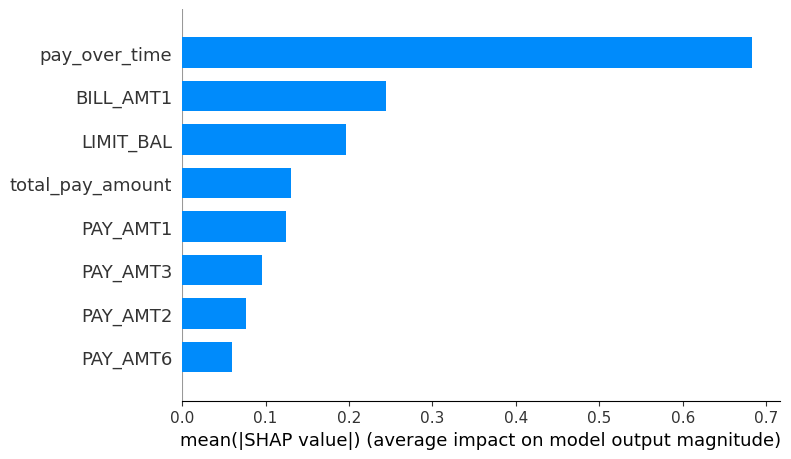

In [28]:
# using SHAP to find the features contributing to prediction in descending order
import shap
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Finding Optimal Threshold: 

<b> Threshold to separate two classes is found using optimal F1 score instead of using 0.5

Best Threshold=0.614979, F-Score=0.538


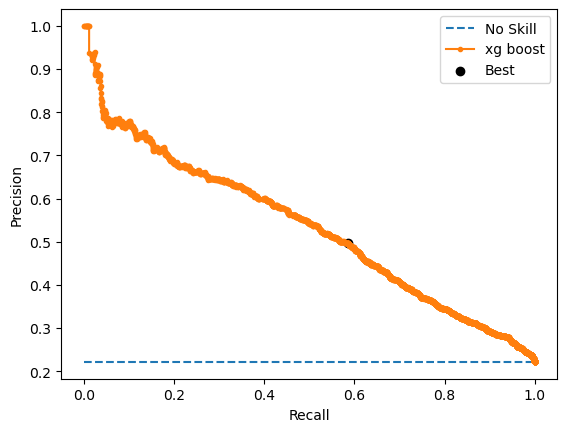

In [29]:
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

# predict probabilities
yhat = clf_xgb.predict_proba(X_test)[:, 1]

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(Y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='xg boost')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()
plt.rcParams["figure.figsize"] = (5,5)

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
thresh = 0.614979 # threshold with the highest f1 score is calculated from the above
y_pred[yhat> thresh] = 1
y_pred[yhat <= thresh] = 0
cm = confusion_matrix(Y_test, y_pred)
cm

array([[3823,  774],
       [ 542,  766]])

In [31]:
yhat = clf_xgb.predict_proba(X_test)[:, 1]
print('test classification report')
print(metrics.classification_report(Y_test, y_pred)) 
print("Balanced Accuracy: %.4g" % metrics.balanced_accuracy_score(Y_test, y_pred))
print("test AUC : %f" % metrics.roc_auc_score(Y_test, yhat))

test classification report
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      4597
           1       0.50      0.59      0.54      1308

    accuracy                           0.78      5905
   macro avg       0.69      0.71      0.70      5905
weighted avg       0.79      0.78      0.78      5905

Balanced Accuracy: 0.7086
test AUC : 0.776310


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
